### Imports

In [1]:
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
import seaborn as sns
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.feature_extraction.text import CountVectorizer
import spacy
from tqdm import tqdm
import pickle
from nltk.corpus import stopwords
import re

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score

from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline
from nltk.stem.porter import PorterStemmer
from collections import Counter
from scipy.sparse import hstack


### Loading datasets

In [2]:
df_sample_submission = pd.read_csv('datasets/sample_submission.csv')
df_test = pd.read_csv('datasets/test.csv')
df_train = pd.read_csv('datasets/train.csv')

In [3]:
pd.set_option('max_colwidth',None) #setting columnd width so we can see whole text

### EDA

In [4]:
display(df_sample_submission.sample(3))
display(df_test.sample(3))
display(df_train.sample(3))

,id,target
610,1993,0
3181,10549,0
982,3250,0


,id,keyword,location,text
2574,8590,screams,New York,The screams when Niall touches his dick yes http://t.co/U5Iu6pfNh6
645,2105,casualty,NaN,?please read casualty fans?\nLet us know &amp; help spread the word by retweeting! DM me or @ScriptetteSar for more info?? http://t.co/HDrBTJRoHb
1759,5945,hazard,"Oro Valley, AZ",@mishavelgos @MattBacal8 @ComplexMag this is so accurate I can't even speak haha... Comparing hazard to harden is so true


,id,keyword,location,text,target
3734,5306,fear,"Hilton Head, SC",@SenSanders Gd ideas. I'm 77 wrked hard now have almost nothing fear lives with poor\nFran Reed 8437150124,0
5195,7416,obliterated,NaN,We destroyed the #Zimmerman fan club on Twitter @rzimmermanjr and we obliterated Renewsit reduced her to a sock acc. http://t.co/ybshleIE3p,0
7596,10851,NaN,NaN,RT @LivingSafely: #NWS issues Severe #Thunderstorm Warnings for parts of #AR #NC #OK. Expect more trauma cases: http://t.co/FWqfCKNCQW,1


<AxesSubplot:xlabel='target', ylabel='count'>

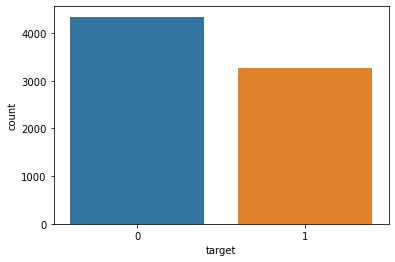

In [5]:
sns.countplot(x = df_train["target"], data = df_train)

#### N-gram analyze

In [6]:
corpus = df_train['text'].values

In [7]:
def clear_text(text):
    return " ".join(re.sub(r'[^a-zA-Z ]', ' ', text).split())  


In [8]:
stop_words = set(stopwords.words('english'))
preprocessed_corpus=[]
for i in tqdm(range(len(corpus))):
    preprocessed_corpus.append((clear_text(str.lower(corpus[i]))))

100%|██████████████████████████████████████████████████████████████████████████| 7613/7613 [00:00<00:00, 169634.06it/s]


In [9]:
def ngrams_analyze(corpus,stop_words,ngram_size):
    '''
    The funciton analyzez and plots most used  ngrams in given corpus
    '''
    count_vect = CountVectorizer(ngram_range=(ngram_size, ngram_size),stop_words=stop_words) 
    bow = count_vect.fit_transform(preprocessed_corpus) 
   
    word_list=count_vect.get_feature_names() 
    count_list = bow.sum(axis=0).A1
    x = dict(zip(word_list,count_list))
    g={k: v for k, v in sorted(x.items(), key=lambda item: item[1],reverse=True)}
    result_series = pd.Series(g)
    print(f'Most frequently used {ngram_size}-grams in corpus: ')
    print(result_series[0:20])
    
    plt.figure(figsize=(15,8))
    sns.barplot(y=result_series[0:20].index, x=result_series[0:20].values,color='blue')
    plt.title("Threegramm_frequency")
    plt.show()
    

Most frequently used 1-grams in corpus: 
co           4741
http         4309
https         412
like          348
amp           344
fire          254
get           229
new           228
via           220
news          213
people        200
one           199
video         166
disaster      158
emergency     158
police        143
would         137
us            133
time          132
body          131
dtype: int64


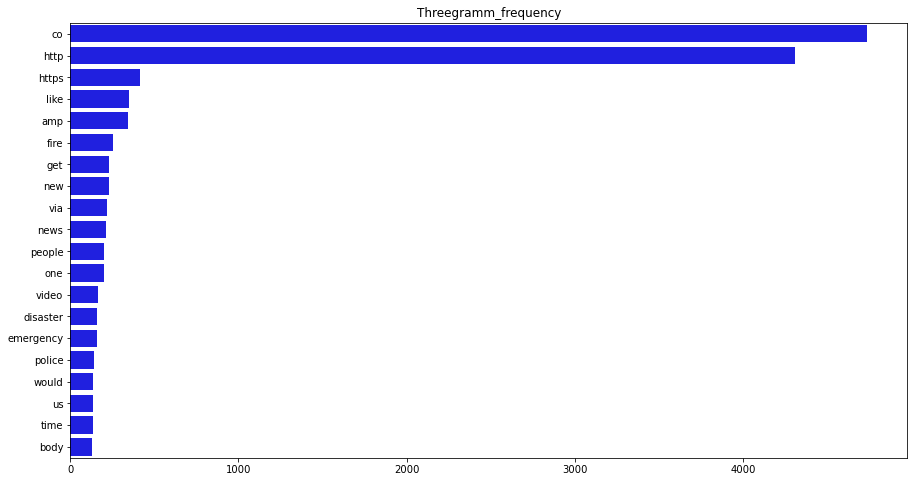

In [10]:
ngrams_analyze(corpus=preprocessed_corpus, stop_words=stop_words, ngram_size=1)

Most frequently used 2-grams in corpus: 
http co                4306
https co                411
burning buildings        59
suicide bomber           59
video http               43
youtube video            43
liked youtube            42
northern california      41
cross body               40
oil spill                39
suicide bombing          36
california wildfire      34
year old                 34
looks like               33
news http                33
mass murder              32
full read                31
heat wave                31
mass murderer            31
natural disaster         31
dtype: int64


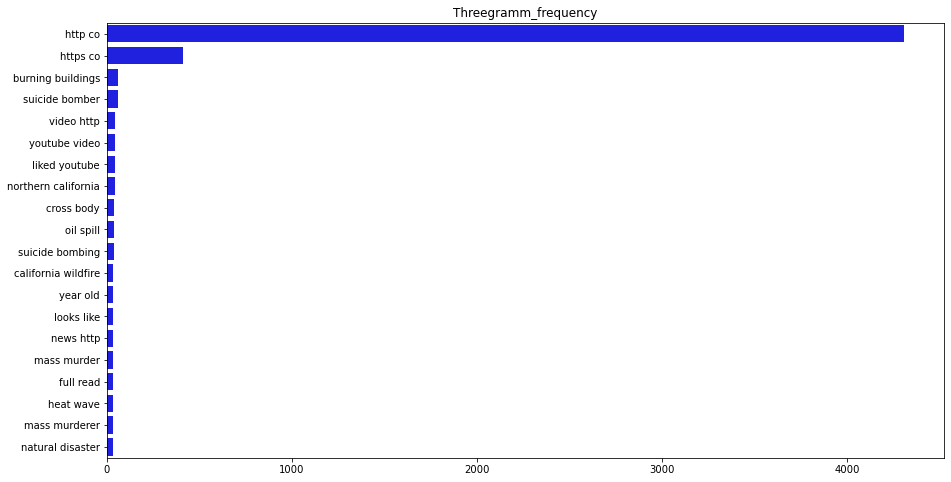

In [11]:
ngrams_analyze(corpus=preprocessed_corpus, stop_words=stop_words, ngram_size=2)

Most frequently used 3-grams in corpus: 
video http co                     43
liked youtube video               42
news http co                      33
suicide bomber detonated          30
northern california wildfire      29
bomber detonated bomb             28
homes razed northern              28
latest homes razed                28
pkk suicide bomber                28
full http co                      27
old pkk suicide                   27
razed northern california         27
yr old pkk                        27
affected fatal outbreak           26
families affected fatal           26
families sue legionnaires         26
declares disaster typhoon         25
disaster typhoon devastated       25
legionnaires families affected    25
obama declares disaster           25
dtype: int64


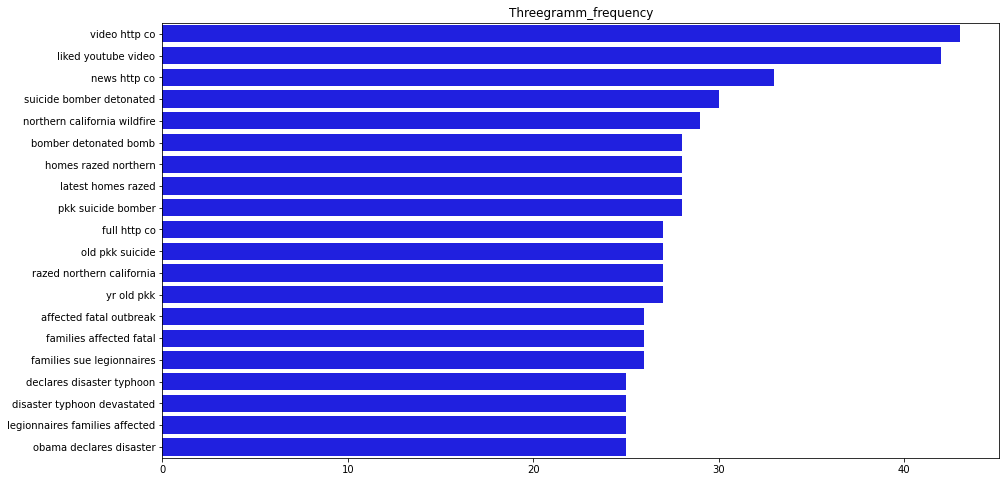

In [12]:
ngrams_analyze(corpus=preprocessed_corpus, stop_words=stop_words, ngram_size=3)

#### Functions for cleaning up the text

In [13]:
#This function accepts a string and uses regular expressions
#to remove URLs from the string, before returning the cleaned string.
def remove_URL(text):
  url = re.compile(r'https?://\S+|www\.\S+')
  return url.sub(r'',text)

#This function accepts a string and uses regular expressions
#to remove HTML tags from the string, before returning the cleaned string.
def remove_html(text):
  html=re.compile(r'<.*?>')
  return html.sub(r'',text)

#This function accepts a string and uses regular expressions
#to remove Twitter mentions from the string, before returning the cleaned string.
def remove_mentions(text):
  return re.sub("@[A-Za-z0-9]+","",text)

#This function accepts a string and uses regular expressions
#to remove emojis from the string, before returning the cleaned string.

# Reference : https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b
def remove_emoji(text):
  emoji_pattern = re.compile("["
  u"\U0001F600-\U0001F64F"  # Emoticons
  u"\U0001F300-\U0001F5FF"  # Symbols & Pictographs
  u"\U0001F680-\U0001F6FF"  # Transport & Map symbols
  u"\U0001F1E0-\U0001F1FF"  # IOS Flags
  u"\U00002500-\U00002BEF"  # Chinese characters
  u"\U00002702-\U000027B0"
  u"\U00002702-\U000027B0"
  u"\U000024C2-\U0001F251"
  u"\U0001f926-\U0001f937"
  u"\U00010000-\U0010ffff"
  u"\u2640-\u2642"
  u"\u2600-\u2B55"
  u"\u200d"
  u"\u23cf"
  u"\u23e9"
  u"\u231a"
  u"\ufe0f"  # Dingbats
  u"\u3030"
  "]+", flags=re.UNICODE)
  return emoji_pattern.sub(r'', text)

#This function accepts a string and uses regular expressions
#to remove Twitter mentions from the string, before returning the cleaned string.
def remove_mentions(text):
  return re.sub("@[A-Za-z0-9]+","",text)

In [14]:
#THis is arguable thing, probably could drop it
stop_words.update('http','https','co')

In [15]:
#This function will be used to process text to
#create a bag-of-words model.



def text_processor(text:str, stemming:str = 'None',clean_numbers:bool= True):

    """
    Accepts a messy string, cleans it, 
    and then returns the string as list.

    1. Removes URLs and make the string lowercase.
    2. Removes HTML tags.
    3. Removes popular emoji symbols.
    4. Remove Twitter mentions.
    5. Remove punctionation.
    7. Remove numbers.
    8. Remove stopwords/
    9. Remobe any symbol which do not belong to alphabet or numbers.
    10. Make stemming or lemmatization optionally
    11. Return list of cleaned, lowercase words
    """

    #Remove URLs from the string
    cln_str = remove_URL(text).lower()

    #Remove HTML tags from the string
    cln_str = remove_html(cln_str)

    #Remove emoji from the string
    cln_str = remove_emoji(cln_str)



    #Remove Twitter mentions from the string
    cln_str = remove_mentions(cln_str)

    #Removes the punctuation from the string
    nopunc = [char for char in cln_str if char not in string.punctuation]
    cln_str=''.join(nopunc)
    
    
    #Removes digits from the string
    if clean_numbers== True:
        nonum = [char for char in cln_str if char not in string.digits]
        cln_str = ''.join(nonum)
    else:
        pass
    
    #clean text from various symbols not from alphabet or numbers
    cln_str =  " ".join(re.sub(r'[^a-zA-Z0-9]', ' ', cln_str).split())  
    
    #Remove the stopwords and return a cleaned list of words
    cln_str= [word for word in cln_str.split() if word.lower() not in stopwords.words('english')]
      
        
        
    
    if stemming == 'lemmatization':
       
        nlp = spacy.load("en_core_web_sm")
        cln_str = ' '.join(cln_str)
        doc = nlp(cln_str)
        new_text=[]
        cln_str=new_text
        for token in doc:
            new_text.append(token.lemma_)
    if stemming == 'stemming':
        pstem = PorterStemmer()
        new_text =[]
        for word in cln_str:
            new_text.append(pstem.stem(word))
        cln_str=new_text
    
    else:
        pass 

    
    return cln_str

Lets commit an experiment to evaluate LR with different options:

In [16]:
def log_reg_model_evaluate(X,y, model_name):
    '''funciton to build and evaluate model'''
    #Create the features, X, and the target, y,
    #and then split them into training and validation sets.
    

    X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.20,random_state=12345)
    count_tf_idf = TfidfVectorizer(ngram_range =(1,2)) 
    tf_idf = count_tf_idf.fit_transform(X_train.astype(str)) 
    tf_idf2 = count_tf_idf.transform(X_val.astype(str))
    
    
    parameters = {'C':range(1,11,1)}

    log_regr_rand=RandomizedSearchCV(LogisticRegression(class_weight='balanced',penalty='l2'), parameters, cv=5, random_state=12345,scoring='f1',n_jobs =-1)
    log_regr_rand.fit(tf_idf, y_train)
    log_regression_model=log_regr_rand.best_estimator_

    prediction = log_regression_model.predict(tf_idf2)
    log_regression_f1=f1_score(y_val, prediction)
    log_regression_accuracy=accuracy_score(y_val, prediction)
    log_regression_precision=precision_score(y_val, prediction)
    log_regression_recall=recall_score(y_val, prediction)
    
    return (model_name,log_regression_accuracy,log_regression_f1,log_regression_precision,log_regression_recall)

#### Lets expriment with adding columns of keyword. Hence we need to make 

In [17]:
df_train['keyword'] = df_train['keyword'].fillna('empty')
df_train = df_train.drop(columns=('location'))

In [18]:
Xw1= df_train['text'].apply(lambda x:text_processor(text=x,stemming='None',clean_numbers=True))
Xw2=df_train['keyword'].apply(lambda x:text_processor(text=x,stemming='None',clean_numbers=True))


count_tf_idf = TfidfVectorizer(ngram_range =(1,1))
tf_idf1 = count_tf_idf.fit_transform(Xw1.astype(str)) 
count_tf_idf = TfidfVectorizer(ngram_range =(1,1))
tf_idf2 = count_tf_idf.fit_transform(Xw2.astype(str)) 


In [19]:
features = hstack([tf_idf1, tf_idf2])

In [20]:
X_train, X_val, y_train, y_val = train_test_split(features,df_train['target'],test_size=0.20,random_state=12345)


In [21]:
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(6090, 14932)
(1523, 14932)
(6090,)
(1523,)


In [22]:
parameters = {'C':range(1,11,1)}

log_regr_rand=RandomizedSearchCV(LogisticRegression(class_weight='balanced',penalty='l2'), parameters, cv=5, random_state=12345,scoring='f1',n_jobs =-1)
log_regr_rand.fit(X_train, y_train)
#     print('Best params: ',log_regr_rand.best_params_)
#     print('F1 score at training : ',log_regr_rand.best_score_)
log_regression_model=log_regr_rand.best_estimator_

prediction = log_regression_model.predict(X_val)
log_regression_result=f1_score(y_val, prediction)
#     print('F1 score for logistic regression',log_regression_result)



In [23]:
print(f1_score(y_val, prediction))
print(accuracy_score(y_val, prediction))
print(precision_score(y_val, prediction))
print(recall_score(y_val, prediction))


0.7612403100775194
0.7977675640183848
0.7671875
0.7553846153846154


Experiment failed, we got worse metrics

Lets try logistic regression with different preprocessing options

In [24]:
#Let's crete a dataframe to compare model results
df = pd.DataFrame(columns=['model_options', 'accuracy', 'f1','precision','recall']) 



In [25]:
X= df_train['text'].apply(lambda x:text_processor(text=x,stemming='None',clean_numbers=True))
y= df_train['target']
df.loc[len(df)]=log_reg_model_evaluate(X,y,'NO_stemming_NO_numbers')


X= df_train['text'].apply(lambda x:text_processor(text=x,stemming='None',clean_numbers=False))
y= df_train['target']
df.loc[len(df)]=log_reg_model_evaluate(X,y,'NO_stemming,YES_numbers')


X= df_train['text'].apply(lambda x:text_processor(text=x,stemming='stemming',clean_numbers=True))
y= df_train['target']
df.loc[len(df)]=log_reg_model_evaluate(X,y,'St_stemming,NO_numbers')


X= df_train['text'].apply(lambda x:text_processor(text=x,stemming='stemming',clean_numbers=False))
y= df_train['target']
df.loc[len(df)]=log_reg_model_evaluate(X,y,'St_stemming,YES_numbers')


display(df)

,model_options,accuracy,f1,precision,recall
0,NO_stemming_NO_numbers,0.808273,0.773292,0.780564,0.766154
1,"NO_stemming,YES_numbers",0.808273,0.773292,0.780564,0.766154
2,"St_stemming,NO_numbers",0.799081,0.766768,0.759819,0.773846
3,"St_stemming,YES_numbers",0.799081,0.766412,0.760606,0.772308



Lemmatization had been tried also, but it takes ages to complete and gives close to 0 result. While stemming give us some quality points and quick to finish.

Let's experiment with moving threshold in regression

In [26]:
X= df_train['text'].apply(lambda x:text_processor(text=x,stemming='None',clean_numbers=True))
y= df_train['target']
X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.20,random_state=12345)
count_tf_idf = TfidfVectorizer() 
tf_idf = count_tf_idf.fit_transform(X_train.astype(str)) 
tf_idf2 = count_tf_idf.transform(X_val.astype(str))
parameters = {'C':range(1,11,1)}

log_regr_rand=RandomizedSearchCV(LogisticRegression(class_weight='balanced',penalty='l2'), parameters, cv=5, random_state=12345,scoring='f1',n_jobs =-1)
log_regr_rand.fit(tf_idf, y_train)

log_regression_model=log_regr_rand.best_estimator_

prediction = log_regression_model.predict(tf_idf2)

print('f1_score: ',f1_score(y_val, prediction))
print('accuracy_score: ',accuracy_score(y_val, prediction))
print('precision', precision_score(y_val, prediction))
print('recall', recall_score(y_val, prediction))      

predictions_proba= log_regr_rand.predict_proba(tf_idf2)


f1_score:  0.7597851112816577
accuracy_score:  0.7944845699277742
precision 0.7580398162327718
recall 0.7615384615384615


In [28]:
f1_best = 0
threshold=0
for i in tqdm(range(45,55,1)):
    predictions=((predictions_proba[:, 0] < (i/100))*1)
    f1=f1_score(predictions,y_val)

    if f1 > f1_best:
        f1_best=f1
        threshold =(i/100)
print(threshold)
print(f1_best)

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 771.03it/s]

0.51
0.7631378522467631


Moving threshold didn't add much to resulting score since recall and precision are pretty close.

#### Light GBM Classifier

In [34]:
parameters = {"num_leaves": range(2, 110, 10), 
              "n_estimators": range(30, 500, 20),
             "learning_rate":[0.01,0.05,0.1],
              "max_depth":[-1,6],
              "colsample_bytree": [0.7,0.8,0.9],
              "reg_alpha": [0.1,0.15,0.2],
              "reg_lambda": [0.1,0.15,0.2],
              "min_child_samples": [15,20,25]         
                       
             }

LGBM_search = RandomizedSearchCV(
    LGBMClassifier(class_weight="balanced", importance_type="gain"),
    parameters,
    cv=5,
    random_state=12345,
    scoring="f1",
    n_jobs=-1,n_iter=300
)

LGBM_search.fit(tf_idf, y_train)

model_lgbm_class = LGBM_search.best_estimator_
predictions_lgbm = model_lgbm_class.predict(tf_idf2)

print("LGBM Classifier f1_score: ", f1_score(y_val, predictions_lgbm))
print('LGBM Classifier accuracy_score: ',accuracy_score(y_val, predictions_lgbm))
print('LGBM Classifier precision', precision_score(y_val, predictions_lgbm))
print('LGBM Classifier recall', recall_score(y_val, predictions_lgbm))      



LGBM Classifier f1_score:  0.7474589523064894
LGBM Classifier accuracy_score:  0.7879185817465528
LGBM Classifier precision 0.7599364069952306
LGBM Classifier recall 0.7353846153846154


In [35]:
LGBM_search.best_estimator_

LGBMClassifier(class_weight='balanced', colsample_bytree=0.8,
               importance_type='gain', learning_rate=0.05, min_child_samples=15,
               n_estimators=170, num_leaves=72, reg_alpha=0.15, reg_lambda=0.2)

LGBM Classifier performed worse than LogisticRegression

### Let's make common dataset cosnsisting of df_train df_test. We will traine TF-IDF Vectorizer on both train and test text datasets

In [36]:
df_test['target']=np.nan

df_full=pd.concat([df_train,df_test])
df_full=df_full.reset_index()

In [37]:
#Create the features, X, and the target, y,
#and then split them into training and validation sets.
X, y = df_full['text'].apply(lambda x:text_processor(text=x,stemming='stemming',clean_numbers=True)), df_full['target']
X_train, X_val, = X.loc[lambda x:x.index<=7612],X.loc[lambda x:x.index>7612]
y_train, y_val = y.loc[lambda x:x.index<=7612],y.loc[lambda x:x.index>7612]
#The validation set will be 20% of the training data, as set by the test_size parameter

In [38]:
count_tf_idf = TfidfVectorizer(ngram_range =(1,2)) 
tf_idf = count_tf_idf.fit_transform(X_train.astype(str)) 
tf_idf2 = count_tf_idf.transform(X_val.astype(str))

In [39]:
import warnings
warnings.filterwarnings("ignore") #There are a lot of warnings, here we will skip them

try:

    parameters = {
        'C':range(1,10,1),
        'class_weight': ['balanced'],
        'penalty':['l1', 'l2', 'elasticnet'],
        'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']

    }

    log_regr_rand=RandomizedSearchCV(estimator = LogisticRegression(), param_distributions=parameters, cv=5, random_state=12345,scoring='f1',n_iter=30)
    log_regr_rand.fit(tf_idf, y_train)
    print('Best params: ',log_regr_rand.best_params_)
    print('F1 score at training : ',log_regr_rand.best_score_)
    log_regression_model=log_regr_rand.best_estimator_

    prediction_lot_reg = log_regression_model.predict(tf_idf2)
except:
    pass

Best params:  {'solver': 'saga', 'penalty': 'l2', 'class_weight': 'balanced', 'C': 1}
F1 score at training :  0.6222633580947178


#### Submission to Kaggle

In [40]:
df_test['target']=np.nan
df_test['target']=prediction_lot_reg
df_sample_submission = df_test[['id','target']]

df_sample_submission['target']=df_sample_submission['target'].astype('int64')

df_sample_submission.head(3)

df_sample_submission.to_csv('df_sample_sub_26-10.csv',index=False)

**Score at Kaggle: 0.79742 **




P.S.

1. Threr is a problem with lemmatization since used library changes negative parts into positive. "Don't" - do , "didn't" - "did" etc. We can use another
2. Lemmatization was tried and give reduction in quality and was very slow at the same time. 

3. LGBM Classifier had been tried as well but gives poor performance
4. Bigrams (1;2) performed way better than (1,1) as a parametr of TfIDfVectorizer.